In [1]:
import numpy as np
npz = np.load('/home/e19b516g/yejing/data/data_for_graph/npz/val/form_5_648_E3236.npz')

In [3]:
print(npz['edge_labels'])

[[0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [8. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 8. 0. 2. 2. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 1. 2. 2. 2. 0. 0.]
 [0. 0. 8. 1. 0. 2. 2. 2. 0. 0.]
 [0. 0. 0. 8. 8. 0. 1. 1. 2. 2.]
 [0. 0. 0. 8. 8. 1. 0. 1. 2. 2.]
 [0. 0. 0. 8. 8. 1. 1. 0. 2. 2.]
 [0. 0. 0. 0. 0. 8. 8. 8. 0. 1.]
 [0. 0. 0. 0. 0. 8. 8. 8. 1. 0.]]


In [6]:
import torch
a = torch.tensor([[0,1],[1,0]])
# fill the diagonal with 1
a.fill_diagonal_(1)

tensor([[1, 1],
        [1, 1]])

In [2]:
print(npz['strokes_emb'].shape)

(10, 100, 2)


In [3]:
print(npz['stroke_labels'].shape)

(10,)


In [6]:
import torch
nn = torch.empty(0, 100, 2)

In [8]:
emb = torch.ones(10,100,2)
nn = torch.cat((nn, emb), 0)

In [11]:
nn = torch.cat((nn, torch.zeros(3,100,2)), 0)

In [12]:
nn.shape

torch.Size([13, 100, 2])

In [16]:
y = torch.load('/home/e19b516g/yejing/data/data_for_graph/S100_R5_Speed_False/val_y.pt')
X = torch.load('/home/e19b516g/yejing/data/data_for_graph/S100_R5_Speed_False/val_X.pt')

In [17]:
print(y.shape)
print(X.shape)

torch.Size([24406])
torch.Size([24406, 100, 2])


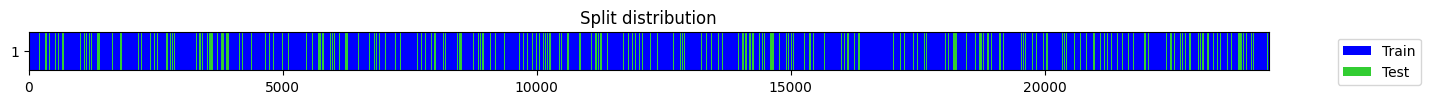

In [19]:
from tsai.all import *
s = get_splits(y, valid_size=0.2, random_state=42)

In [34]:
s

((#19525) [5164,10121,18887,8800,17783,12934,15168,16906,11471,4815...],
 (#4881) [14517,14602,24129,7720,22173,7705,20993,17632,332,15593...])

In [38]:
# create tuple sss[1] 0~100, sss[2] 101~200
sss = (list(range(0,12)), list(range(12,20)))

In [39]:
sss

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18, 19])

In [2]:
import torch

ckpt = torch.load('/home/e19b516g/yejing/code/Edge_GAT/pretrain_logs/S100_R5_Speed_False_lr_0.001/version_1/checkpoints/epoch=22-step=120037.ckpt',map_location=torch.device('cpu'))

In [13]:
from Model.LitModel import LitModel
model = LitModel(
    node_input_size = 100,
    edge_input_size = 20,
    gat_input_size = 128,
    gat_hidden_size = 64,
    gat_output_size = 128,
    gat_n_heads = 8,
    node_class_nb = 114,
    edge_class_nb = 14,
    dropout = 0.6,
    lambda1 = 0.5,
    lambda2 =  0.5,
    lr = 1e-3,
    device = 'cpu'
)
# model.load_state_dict(ckpt, strict=False)

node_emb {'Total': 429620, 'Trainable': 429620}
edge_emb {'Total': 2688, 'Trainable': 2688}
gat1 {'Total': 8208, 'Trainable': 8208}
gat2 {'Total': 8448, 'Trainable': 8448}
readout_node {'Total': 14706, 'Trainable': 14706}
readout_edge {'Total': 1806, 'Trainable': 1806}


In [20]:
model.load_state_dict(ckpt, strict=False)

_IncompatibleKeys(missing_keys=['model.node_emb.block.xception.0.bottleneck.weight', 'model.node_emb.block.xception.0.convs.0.depthwise_conv.weight', 'model.node_emb.block.xception.0.convs.0.pointwise_conv.weight', 'model.node_emb.block.xception.0.convs.1.depthwise_conv.weight', 'model.node_emb.block.xception.0.convs.1.pointwise_conv.weight', 'model.node_emb.block.xception.0.convs.2.depthwise_conv.weight', 'model.node_emb.block.xception.0.convs.2.pointwise_conv.weight', 'model.node_emb.block.xception.0.maxconvpool.1.weight', 'model.node_emb.block.xception.1.bottleneck.weight', 'model.node_emb.block.xception.1.convs.0.depthwise_conv.weight', 'model.node_emb.block.xception.1.convs.0.pointwise_conv.weight', 'model.node_emb.block.xception.1.convs.1.depthwise_conv.weight', 'model.node_emb.block.xception.1.convs.1.pointwise_conv.weight', 'model.node_emb.block.xception.1.convs.2.depthwise_conv.weight', 'model.node_emb.block.xception.1.convs.2.pointwise_conv.weight', 'model.node_emb.block.xcep

In [34]:

for name, param in model.named_parameters():
    print(name, param.shape)

model.node_emb.block.xception.0.bottleneck.weight torch.Size([16, 100, 1])
model.node_emb.block.xception.0.convs.0.depthwise_conv.weight torch.Size([16, 1, 39])
model.node_emb.block.xception.0.convs.0.pointwise_conv.weight torch.Size([16, 16, 1])
model.node_emb.block.xception.0.convs.1.depthwise_conv.weight torch.Size([16, 1, 19])
model.node_emb.block.xception.0.convs.1.pointwise_conv.weight torch.Size([16, 16, 1])
model.node_emb.block.xception.0.convs.2.depthwise_conv.weight torch.Size([16, 1, 9])
model.node_emb.block.xception.0.convs.2.pointwise_conv.weight torch.Size([16, 16, 1])
model.node_emb.block.xception.0.maxconvpool.1.weight torch.Size([16, 100, 1])
model.node_emb.block.xception.1.bottleneck.weight torch.Size([32, 64, 1])
model.node_emb.block.xception.1.convs.0.depthwise_conv.weight torch.Size([32, 1, 39])
model.node_emb.block.xception.1.convs.0.pointwise_conv.weight torch.Size([32, 32, 1])
model.node_emb.block.xception.1.convs.1.depthwise_conv.weight torch.Size([32, 1, 19])


In [40]:
# new_state_dict = OrderedDict()
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in ckpt['state_dict'].items():
    # print(k, v.shape)
    # print(k[:6] + 'node_emb.' + k[6:])
    new_state_dict[k[:6] + 'node_emb.' + k[6:]] = v

In [43]:
import pre_train
model_x = pre_train.LightModel()
model_x.load_state_dict(new_state_dict, strict=False)

usage: ipykernel_launcher.py [-h] [--root_path ROOT_PATH]
                             [--stroke_emb_nb STROKE_EMB_NB]
                             [--stroke_class_nb STROKE_CLASS_NB]
                             [--epoch EPOCH] [--batch_size BATCH_SIZE]
                             [--num_workers NUM_WORKERS] [--shuffle SHUFFLE]
                             [--lr LR] [--min_delta MIN_DELTA]
                             [--patience PATIENCE] [--device DEVICE]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"b5e32e81-3836-4c0f-932d-b9fe6bdc3c92" --shell=9002 --transport="tcp" --iopub=9004 --f=/home/e19b516g/.local/share/jupyter/runtime/kernel-v2-34681qyUpLd5QJVOS.json


SystemExit: 2

In [46]:
test = torch.tensor([[1,2,3],[4,5,6]])
test.unsqueeze(-1).shape

torch.Size([2, 3, 1])

In [48]:
import numpy as np
import os

In [127]:
npz_path = '/home/e19b516g/yejing/data/data_for_graph/npz/train'
node_nb = []
edge_nb = []
for _, _, files in os.walk(npz_path):
    for file in files:
        if file.endswith('.npz'):
            npz =np.load(os.path.join(npz_path, file))
            node_nb.append(npz['strokes_emb'].shape[0])
            edge_nb.append(np.sum(npz['los'] == 1))

In [120]:
nnn = np.load('/home/e19b516g/yejing/data/data_for_graph/npz/train/001-equation000.npz')
nnn['edge_labels'].shape

(11, 11)

(array([6.590e+02, 1.251e+03, 7.140e+02, 1.295e+03, 1.142e+03, 4.410e+02,
        7.570e+02, 8.500e+02, 4.540e+02, 7.790e+02, 3.470e+02, 6.270e+02,
        5.970e+02, 2.980e+02, 3.780e+02, 3.720e+02, 1.150e+02, 2.100e+02,
        6.700e+01, 1.410e+02, 1.170e+02, 4.600e+01, 6.100e+01, 6.800e+01,
        2.400e+01, 4.500e+01, 1.700e+01, 3.300e+01, 3.100e+01, 6.000e+00,
        2.100e+01, 9.000e+00, 9.000e+00, 1.400e+01, 4.000e+00, 3.000e+00,
        5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1.        ,   2.62857143,   4.25714286,   5.88571429,
          7.51428571,   9.14285714,  10.77142857,  12.4       ,
    

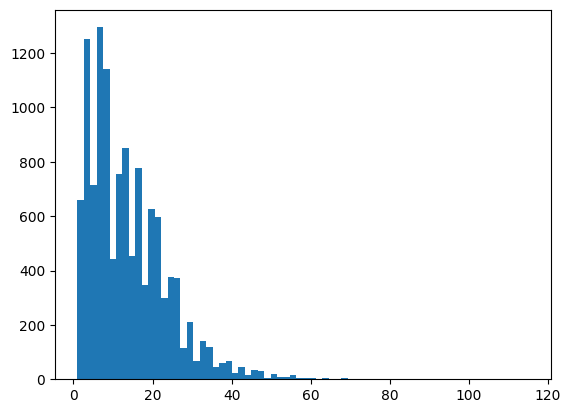

In [63]:
import matplotlib.pyplot as plt
plt.hist(np.array(node_nb), bins=70)

In [68]:
node_nb = np.array(node_nb)
node_nb.max()

115

(array([5.558e+03, 2.250e+03, 1.528e+03, 1.068e+03, 5.810e+02, 3.440e+02,
        2.240e+02, 1.420e+02, 9.300e+01, 6.700e+01, 4.200e+01, 3.700e+01,
        2.100e+01, 2.200e+01, 9.000e+00, 7.000e+00, 5.000e+00, 1.300e+01,
        4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   0.  ,   70.52,  141.04,  211.56,  282.08,  352.6 ,  423.12,
         493.64,  564.16,  634.68,  705.2 ,  775.72,  846.24,  916.76,
         987.28, 1057.8 , 1128.32, 1198.84, 1269.36, 1339.88, 1410.4 ,
        1480.92, 1551.44, 1621.96, 1692.48, 1763.  , 1833.52, 1904.04,
        1974.56, 2045.08, 2115.6 , 2186.12, 2256.64, 2327.16, 2397.68,
        2468.2 , 2538

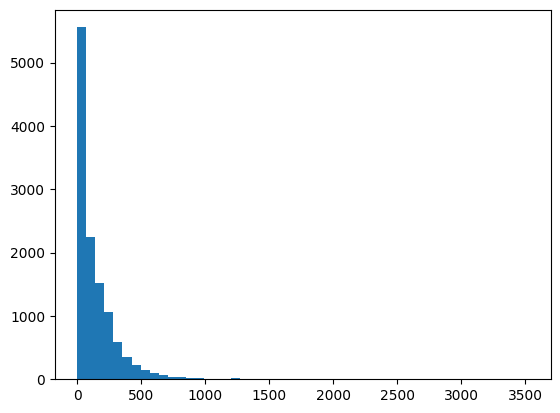

In [67]:
plt.hist(np.array(edge_nb), bins=50)

In [80]:
def balance_graphs(node_counts, edge_counts, nodes_per_group):
    # Calculate the total number of nodes and groups
    total_nodes = sum(node_counts)
    num_groups = total_nodes // nodes_per_group
    
    # Initialize groups
    groups = [[] for _ in range(num_groups)]
    
    # Create a list of (index, node_count, edge_count) tuples
    graphs = list(enumerate(zip(node_counts, edge_counts)))
    
    # Sort graphs in descending order of edge_counts
    sorted_graphs = sorted(graphs, key=lambda x: x[1][1], reverse=True)
    
    # Distribute graphs into groups
    for index, (nodes, edges) in sorted_graphs:
        for group in groups:
            if sum(graphs[i][1][0] for i in group) + nodes <= nodes_per_group:
                group.append(index)
                break
    
    return groups

# Example usage:
# node_counts = [10, 15, 8, 12, 7]  # List of node counts
# edge_counts = [20, 30, 25, 18, 14]  # List of edge counts
# num_groups = 2  # Set the number of groups



Group 0:
  Graph 6954 with 115 nodes and 3526 edges
  Graph 3556 with 13 nodes and 142 edges
  Total: 128 nodes and 3668 edges

Group 1:
  Graph 2769 with 70 nodes and 1910 edges
  Graph 3825 with 58 nodes and 1312 edges
  Total: 128 nodes and 3222 edges

Group 2:
  Graph 1939 with 92 nodes and 1774 edges
  Graph 3782 with 36 nodes and 772 edges
  Total: 128 nodes and 2546 edges

Group 3:
  Graph 10816 with 64 nodes and 1696 edges
  Graph 1926 with 62 nodes and 1372 edges
  Graph 23 with 2 nodes and 2 edges
  Total: 128 nodes and 3070 edges

Group 4:
  Graph 1776 with 67 nodes and 1688 edges
  Graph 10075 with 51 nodes and 1270 edges
  Graph 1385 with 10 nodes and 88 edges
  Total: 128 nodes and 3046 edges

Group 5:
  Graph 666 with 69 nodes and 1510 edges
  Graph 2217 with 59 nodes and 1264 edges
  Total: 128 nodes and 2774 edges

Group 6:
  Graph 10138 with 75 nodes and 1468 edges
  Graph 1405 with 51 nodes and 1258 edges
  Graph 53 with 2 nodes and 2 edges
  Total: 128 nodes and 272

In [129]:
import itertools

def balance_graphs(node_counts, edge_counts, nodes_per_group):
    num_groups = sum(node_counts) // nodes_per_group
    num_graphs = len(node_counts)

    # Calculate the total number of edges
    total_edges = sum(edge_counts)

    # Sort graphs by edge counts in ascending order
    sorted_graphs = sorted(enumerate(edge_counts), key=lambda x: x[1])

    # Initialize group assignments
    group_assignments = [-1] * num_graphs

    # Initialize group statistics
    group_node_sums = [0] * num_groups
    group_edge_sums = [0] * num_groups

    for graph_idx, edge_count in sorted_graphs:
        # Try to add the graph to the group with the smallest sum of nodes
        min_group = group_node_sums.index(min(group_node_sums))
        if group_assignments[graph_idx] == -1:
            if group_node_sums[min_group] + node_counts[graph_idx] <= nodes_per_group:
                group_assignments[graph_idx] = min_group
                group_node_sums[min_group] += node_counts[graph_idx]
                group_edge_sums[min_group] += edge_count

    # If there are unassigned graphs, assign them to the group with the smallest edge sum
    for graph_idx, edge_count in sorted_graphs:
        if group_assignments[graph_idx] == -1:
            min_group = group_edge_sums.index(min(group_edge_sums))
            group_assignments[graph_idx] = min_group
            group_edge_sums[min_group] += edge_count

    # Organize the groups
    groups = [[] for _ in range(num_groups)]
    for graph_idx, group_idx in enumerate(group_assignments):
        groups[group_idx].append(graph_idx)
    return groups



In [130]:
groups = balance_graphs(node_nb, edge_nb, 128)

for i, group in enumerate(groups):
    node_sum = 0
    edge_sum = 0
    print(f'Group {i}:')
    for index in group:
        nodes, edges = node_nb[index], edge_nb[index]
        node_sum += nodes
        edge_sum += edges
        print(f'  Graph {index + 1} with {nodes} nodes and {edges} edges')
    print(f'  Total: {node_sum} nodes and {edge_sum} edges\n')


[103, 126, 105, 117, 97, 103, 99, 108, 125, 106, 105, 102, 102, 114, 102, 128, 104, 127, 97, 104, 97, 103, 104, 99, 125, 128, 107, 127, 126, 98, 108, 121, 106, 128, 127, 118, 105, 112, 98, 100, 127, 97, 105, 102, 101, 103, 103, 105, 106, 104, 99, 111, 100, 100, 111, 101, 98, 104, 104, 106, 102, 122, 102, 103, 112, 104, 106, 104, 106, 108, 97, 105, 102, 102, 100, 106, 105, 102, 99, 97, 106, 127, 108, 98, 106, 101, 105, 105, 101, 104, 102, 110, 102, 100, 108, 103, 114, 104, 113, 99, 105, 102, 104, 100, 108, 103, 106, 124, 106, 107, 128, 103, 107, 99, 109, 107, 105, 111, 103, 100, 101, 111, 106, 106, 110, 100, 125, 106, 97, 99, 111, 112, 127, 113, 109, 110, 104, 101, 98, 109, 101, 117, 107, 113, 102, 110, 109, 103, 104, 98, 97, 104, 114, 103, 106, 105, 103, 112, 101, 101, 107, 108, 104, 108, 103, 103, 109, 100, 105, 106, 108, 128, 100, 116, 104, 107, 101, 110, 101, 110, 107, 105, 98, 103, 117, 128, 119, 105, 103, 110, 102, 113, 109, 100, 98, 102, 105, 102, 104, 102, 108, 106, 103, 100, 11

1304


In [104]:
from Dataset.Datamodule import CROHMEDatamodule
dm = CROHMEDatamodule(
    root_path = npz_path,
    shuffle = True,
    num_workers = 0,
    reload_dataloaders_every_n_epochs=1
)


{'root_path': '/home/e19b516g/yejing/data/data_for_graph/npz/train', 'shuffle': True, 'num_workers': 0, 'reload_dataloaders_every_n_epochs': 1}


In [110]:
list = ['N2E20_form_5_673_E3363', 'N5E29_form_5_673_E3363', 'N25E290_form_5_673_E3363']
# get number behind N and E in the list
import re
node_nb = []
edge_nb = []
for i in list:
    n = i.split('_')[0]
    node_nb.append(n.split('E')[0].split('N')[1])
    edge_nb.append(n.split('E')[1])

In [111]:
edge_nb

['20', '29', '290']

In [124]:
x_rand = torch.rand(3, 3, 4, 5)
xx = torch.zeros(0, 0, 4, 5)
xx = torch.cat((xx, x_rand), dim=2)

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 0 but got size 3 for tensor number 1 in the list.

In [3]:
import torch
g_ = torch.rand(3, 8, 64)
g_r = g_.repeat(3, 1, 1)
g_r_i = g_.repeat_interleave(3, dim=0)
print(g_r.shape)
print(g_r_i.shape)

torch.Size([9, 8, 64])
torch.Size([9, 8, 64])


In [13]:
b = torch.rand(9, 8, 32)

In [7]:
g_con = torch.cat([g_r, g_r_i], dim=-1)

In [15]:
torch.cat([g_r, g_r_i, b], dim=-1).shape

torch.Size([9, 8, 160])

In [31]:
results = torch.load('/home/e19b516g/yejing/code/Edge_GAT/val_results/S100_R5_Speed_False/lr_0.001_bs_256_epoch_100_dropout_0.6_l1_0.8_l2_0.6/version_2/epoch_12.pt', map_location=torch.device('cpu'))

In [37]:
results[0][0]

tensor([[7.9375e-13, 3.4153e-11, 9.2336e-12,  ..., 1.2355e-12, 1.4971e-12,
         1.2303e-12],
        [2.5261e-14, 9.0140e-13, 2.3017e-13,  ..., 3.4096e-14, 4.0626e-14,
         3.8991e-14],
        [3.5939e-13, 1.0158e-11, 2.8609e-12,  ..., 4.7072e-13, 5.3391e-13,
         5.3509e-13],
        ...,
        [5.0272e-13, 2.4004e-11, 5.9171e-12,  ..., 3.3688e-13, 6.4414e-13,
         4.9212e-13],
        [1.4532e-12, 8.1273e-11, 2.0334e-11,  ..., 1.0197e-12, 2.0639e-12,
         1.3418e-12],
        [2.5338e-14, 1.2270e-12, 3.0121e-13,  ..., 1.6383e-14, 3.3479e-14,
         2.5348e-14]])

In [47]:
for i in range(len(results)):
    for j in range(len(results[i])):
        print(results[i][2])

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0015e-01, 6.8637e-02, 7.7410e-02,  ..., 7.1376e-02, 6.5634e-02,
         7.1067e-02],
        ...,
        [1.0000e+00, 9.4609e-23, 1.0488e-21,  ..., 1.9818e-25, 5.3267e-25,
         6.2328e-25],
        [1.0000e+00, 1.0720e-17, 6.9429e-17,  ..., 9.6027e-20, 1.9682e-19,
         2.2912e-19],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0015e-01, 6.8637e-02, 7.7410e-02,  ..., 7.1376e-02, 6.5634e-02,
         7.1067e-02],
        ...,
        [1.0000e+00, 9.4609e-23, 1.0488e-21,  ..., 1.9818e-25, 5.3267e-25,
         6.2328e-25],
   